<a href="https://colab.research.google.com/github/Miyairi8/tomoshibi-AIseminar/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.01MB/s]


Epoch 1, Train Loss: 0.2607, Train Accuracy: 92.18%, Test Loss: 0.0789, Test Accuracy: 97.53%
Epoch 2, Train Loss: 0.0676, Train Accuracy: 97.93%, Test Loss: 0.0584, Test Accuracy: 98.22%
Epoch 3, Train Loss: 0.0523, Train Accuracy: 98.33%, Test Loss: 0.0440, Test Accuracy: 98.73%
Epoch 4, Train Loss: 0.0428, Train Accuracy: 98.67%, Test Loss: 0.0419, Test Accuracy: 98.59%
Epoch 5, Train Loss: 0.0378, Train Accuracy: 98.83%, Test Loss: 0.0372, Test Accuracy: 98.78%
Epoch 6, Train Loss: 0.0332, Train Accuracy: 98.94%, Test Loss: 0.0332, Test Accuracy: 98.99%
Epoch 7, Train Loss: 0.0295, Train Accuracy: 99.03%, Test Loss: 0.0383, Test Accuracy: 98.72%
Epoch 8, Train Loss: 0.0270, Train Accuracy: 99.14%, Test Loss: 0.0383, Test Accuracy: 98.83%
Epoch 9, Train Loss: 0.0233, Train Accuracy: 99.23%, Test Loss: 0.0356, Test Accuracy: 98.96%
Epoch 10, Train Loss: 0.0218, Train Accuracy: 99.29%, Test Loss: 0.0344, Test Accuracy: 98.99%


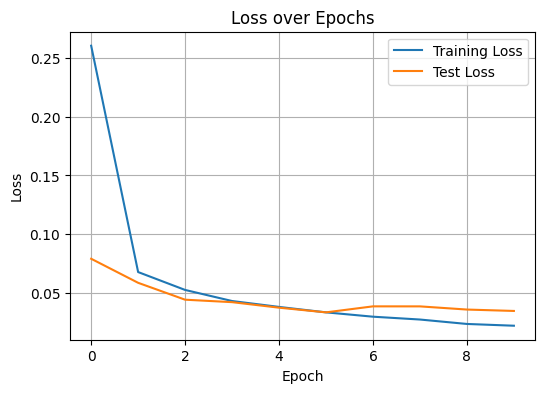

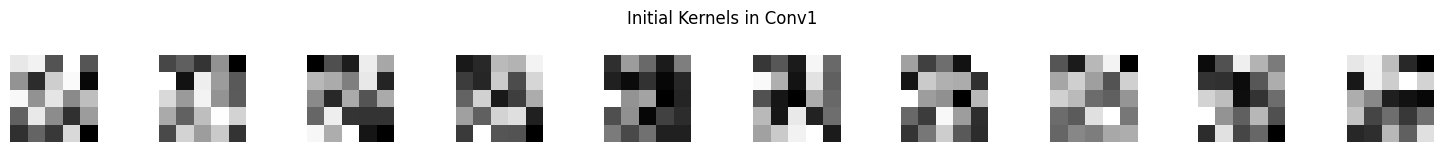

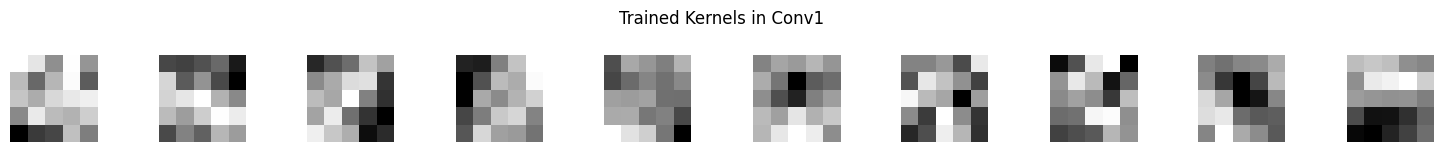

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# ----- ランダムシード固定 -----
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # multi-GPU用
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# ----- データの読み込み -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

g = torch.Generator()
g.manual_seed(42)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, generator=g)

# ----- CNN モデル定義 -----
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # nn.Conv2d(入力チャンネル数, 出力チャンネル数, kernel_size)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 入力チャンネル数は、前層の出力チャンネル数と一致させる
        self.fc1 = nn.Linear(80, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # (batch, 20, 24, 24)   # 畳み込み：5x5レイヤーで両端の2列ずつ分小さくなる
        x = F.max_pool2d(x, 2)          # (batch, 20, 12, 12)   # 最大値プーリング：2x2領域の中の最大値を取って圧縮
        x = F.relu(self.conv2(x))       # (batch, 20, 8, 8)     # 畳み込み：5x5レイヤーで両端の2列ずつ分小さくなる
        x = F.max_pool2d(x, 2)          # (batch, 20, 4, 4)     # 最大値プーリング：2x2領域の中の最大値を取って圧縮
        x = F.max_pool2d(x, 2)          # (batch, 20, 2, 2)
        x = x.view(-1, 80)              # (batch, 2x2x20=80)   # 平坦化：縦x横xチャンネル
        x = F.relu(self.fc1(x))         # (batch, 50)           # 各要素に非線形活性化 φ = relu()
        x = self.fc2(x)                 # (batch, 10)           # 10クラス分類
        return x

# ----- 学習準備 -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ----- 訓練前のカーネルを可視化するために保存しておく -----
with torch.no_grad():
    initial_kernels = model.conv1.weight.cpu().clone()

# ----- 学習ループ -----
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 正答率の計算
        pred = output.argmax(dim=1, keepdim=True)  # 最大スコアのクラスを取得
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)


    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100. * correct / len(test_dataset)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# ----- 損失グラフの描画 -----
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ----- カーネル（第1層）可視化 -----
with torch.no_grad():
    kernels = model.conv1.weight.cpu().clone()  # (out_channels, in_channels, H, W)

num_kernels = min(20, kernels.shape[0])
cols = 10
rows = (num_kernels + cols - 1) // cols

plt.figure(figsize=(1.5 * cols, 1.5 * rows))
for i in range(num_kernels):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(initial_kernels[i][0], cmap='gray')  # 1チャンネルのカーネル
    plt.axis('off')
plt.suptitle('Initial Kernels in Conv1')
plt.tight_layout()
plt.show()

plt.figure(figsize=(1.5 * cols, 1.5 * rows))
for i in range(num_kernels):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(kernels[i][0], cmap='gray')  # 1チャンネルのカーネル
    plt.axis('off')
plt.suptitle('Trained Kernels in Conv1')
plt.tight_layout()
plt.show()